In [1]:
!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [3]:
df = pd.read_excel("IBOVESPA (NBEATSx).xlsx",index_col='Date',parse_dates=True)


In [4]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'Realised':'y'}, inplace=True)
train = df.iloc[:int(len(df['y'])*0.7)]
test = df.iloc[int(len(df['y'])*0.7)]
validation_length=int(len(df['y'])*0.7)-int(len(df['y'])*0.6)

In [ ]:
n_inputs = [12,21,63,84,126,189,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs = [100,150,200]
learning_rate=[0.05,0.005,0.0005,0.0001]
num_lr_decays=[10,5,3,5]
dropouts=[0,0.2,0.4]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[80, 90]),DistributionLoss(distribution='StudentT', level=[80, 90])]
RMSE = []
Accuracy = []

# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 23751287


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 56403130


Epoch: 200 | Inputs: 63 | MLP units: [[100, 100], [100, 100]] | Loss: MQLoss() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.004321069310215056 | Accuracy: 64.15642616022998


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 96200912


Epoch: 200 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001
RMSE: 0.004473250795026312 | Accuracy: 63.29685979645199


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 72187400


Epoch: 100 | Inputs: 84 | MLP units: [[712, 712], [712, 712]] | Loss: DistributionLoss() | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.05
RMSE: 5632574.448963956 | Accuracy: -45580527218.02761


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42811518


Epoch: 200 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001
RMSE: 0.004837317046999238 | Accuracy: 60.069114172325456


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 150 | Inputs: 12 | MLP units: [[100, 100], [100, 100]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.005
RMSE: 0.0038397136948966786 | Accuracy: 68.61901186733928


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 99004289


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80479679


Epoch: 100 | Inputs: 189 | MLP units: [[712, 712], [712, 712]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.05
RMSE: 43.79983700863334 | Accuracy: -406136.25847961043


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 10165832


Epoch: 150 | Inputs: 12 | MLP units: [[250, 250], [250, 250]] | Loss: DistributionLoss() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.003888298499940366 | Accuracy: 68.10892676924087


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59511108


Epoch: 100 | Inputs: 126 | MLP units: [[512, 512], [512, 512]] | Loss: MQLoss() | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001
RMSE: 0.004820660470247225 | Accuracy: 59.984944421008265


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 113765716


Epoch: 200 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001
RMSE: 0.004323977410125894 | Accuracy: 63.90951703672471


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 200 | Inputs: 12 | MLP units: [[250, 250], [250, 250]] | Loss: DistributionLoss() | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.005
RMSE: 0.0037975233657112787 | Accuracy: 68.94016252016564


In [ ]:
for m in range (10):
  i=randrange(6)
  h=randrange(4)
  k=randrange(3)
  l=randrange(4)
  m=randrange(4)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=1, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=[1, 1],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true)
  Accuracy=(1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {losses[m]} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]}")
  print(f"RMSE: {RMSE} | Accuracy: {Accuracy}")

INFO:lightning_fabric.utilities.seed:Global seed set to 121575041


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 39022141


Epoch: 150 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.003985468363468177 | Accuracy: 66.3703078273504


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80305271


Epoch: 100 | Inputs: 189 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005
RMSE: 0.00422409855725157 | Accuracy: 64.36881610697452


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 9043932


Epoch: 150 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.05
RMSE: 0.14116805694301438 | Accuracy: -1188.7724635827994


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 93014663


Epoch: 100 | Inputs: 12 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.05
RMSE: 4.896172565183151 | Accuracy: -42642.31308269378


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 47696465


Epoch: 100 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.005
RMSE: 0.0038419174165749475 | Accuracy: 68.07491277296992


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 27662305


Epoch: 150 | Inputs: 189 | MLP units: [[100, 100], [100, 100]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005
RMSE: 0.004558394266575762 | Accuracy: 62.01303471533538


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 98112309


Epoch: 150 | Inputs: 12 | MLP units: [[512, 512], [512, 512]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.003847409361678073 | Accuracy: 68.47161301673772


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 17551104


Epoch: 200 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0001
RMSE: 0.003950695889702995 | Accuracy: 67.53017801206173


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42313483


Epoch: 200 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: MSE() | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.004058156406181333 | Accuracy: 64.92994948505306


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 200 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: MQLoss() | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.005
RMSE: 0.003943078481130321 | Accuracy: 67.92544939283107


Epoch: 150 | Inputs: 12 | MLP units: [[512, 512], [512, 512]] | Loss: MAE() | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005
RMSE: 0.003847409361678073 | Accuracy: 68.47161301673772

# H=1 Forecasts

In [36]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [6]:
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [29]:
for i in range(1):
  model = NBEATSx(h=1, input_size=12,
                  loss=MAE(),
                  scaler_type='robust',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)

INFO:lightning_fabric.utilities.seed:Global seed set to 13293824


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [30]:
forecasts

,unique_id,ds,cutoff,NBEATSx,y,VIX
0,Airline1,2016-04-19,2016-04-18,0.017427,0.012346,13.240000
1,Airline1,2016-04-20,2016-04-19,0.013831,0.009553,13.280000
2,Airline1,2016-04-21,2016-04-20,0.014571,NaN,NaN
3,Airline1,2016-04-22,2016-04-21,0.014532,0.010575,13.220000
4,Airline1,2016-04-25,2016-04-22,0.013260,0.010619,14.080000
...,...,...,...,...,...,...
1721,Airline1,2023-03-24,2023-03-23,0.011868,0.009296,21.740000
1722,Airline1,2023-03-27,2023-03-24,0.012013,0.006566,20.600000
1723,Airline1,2023-03-28,2023-03-27,0.009794,0.010900,19.969999
1724,Airline1,2023-03-29,2023-03-28,0.009561,0.012744,19.120001


In [27]:
from pandas.tseries.offsets import CustomBusinessDay
holidays=df1['ds'].tolist()

Business_Days = CustomBusinessDay(holidays=holidays)

In [31]:
df1 = forecasts[forecasts.isna().any(axis=1)]

In [32]:
df1

,unique_id,ds,cutoff,NBEATSx,y,VIX
2,Airline1,2016-04-21,2016-04-20,0.014571,NaN,NaN
27,Airline1,2016-05-26,2016-05-25,0.014012,NaN,NaN


In [41]:
for i in range(12):
  model = NBEATSx(h=1, input_size=12,
                  loss=MAE(),
                  scaler_type='robust',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length,step_size=1)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 111751742


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 10865122


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 2891159


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 18505580


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101948099


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 76065817


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 94749813


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 82362154


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 106067152


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 14470384


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 29038484


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 125051834


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [42]:
Accuracy

[69.43521015117547,
 68.35826583811875,
 68.29216772823405,
 69.28394966723914,
 68.5777208795625,
 69.24318084361593,
 69.14505485445201,
 69.46583020845318,
 69.42597898623532,
 69.90937021875281,
 68.90391382001778,
 68.52757257203453,
 69.02058162656122,
 69.24605758016914,
 69.51146639865885]

In [43]:
RMSE

[0.0034075322687618383,
 0.0034574962704903953,
 0.003482061533836338,
 0.0033909275483874264,
 0.0034504417048893776,
 0.0034192618068575897,
 0.0034131478168525926,
 0.0033998432725023823,
 0.0034211995300674983,
 0.003372762973945999,
 0.003414742686291044,
 0.0034334927738969368,
 0.0034173745017631206,
 0.0034303134436141744,
 0.0033987005343517835]

In [44]:
Quasilikelihood

[0.07560194596241876,
 0.07545529092663047,
 0.07762921064387925,
 0.07457846931702683,
 0.07470336420334733,
 0.07638981243972949,
 0.07595789936886012,
 0.07473740452661866,
 0.07748313594913339,
 0.07491906599917741,
 0.0744124234121571,
 0.07407347224912256,
 0.07444768111499171,
 0.07715224760632362,
 0.07592985801723831]

Text(0, 0.5, 'IBOVESPA Realized Volatility')

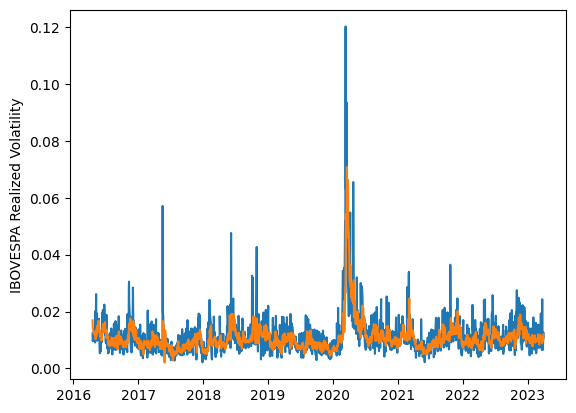

In [45]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("IBOVESPA Realized Volatility")

# H=3 Forecasts

In [56]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]
test_length=len(df["y"])-int(len(df['y'])*0.7)

In [57]:
test_length%3

1

In [58]:
for i in range(15):
  model = NBEATSx(h=3, input_size=12,
                  loss=MAE(),
                  scaler_type='robust',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=9,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%3,step_size=3)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 124138829


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 42132684


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 96119025


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 13026235


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 58255685


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 14839843


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 84889161


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 47010369


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 31648190


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 53657928


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5067616


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 18478179


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 106472946


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 34446050


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 44385071


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [89]:
RMSE

[0.0035393860746925757,
 0.003542730622052195,
 0.003522607302579609,
 0.0035635307974784636,
 0.003553163801582413,
 0.0035700452869319088,
 0.003541999505576516,
 0.003571999220437908,
 0.0035615105425939367,
 0.003562110577702236,
 0.003551828476075102,
 0.0035615743544491177,
 0.0035703068624553373,
 0.003608756153364493,
 0.003570256452731358]

In [91]:
Accuracy


[68.5635873517863,
 68.56770193146859,
 68.41538767291149,
 68.12705929113365,
 67.99919983665012,
 68.20182989427221,
 68.76607319462566,
 68.1817410637272,
 67.7979495713752,
 68.19876457099639,
 68.34049114431691,
 68.32069322875243,
 67.84315892663828,
 67.33393726122539,
 67.89035107009529]

In [93]:
Quasilikelihood

[0.07365196047010912,
 0.0814106487590215,
 0.07896172486898002,
 0.08133401860404862,
 0.08051189834398033,
 0.08190193372662903,
 0.08163536691798245,
 0.083685520596181,
 0.08004151915635788,
 0.08031315871966603,
 0.0808604284439882,
 0.08179917301191537,
 0.08057970637740688,
 0.08046378491794497,
 0.07959974509481141]

Text(0, 0.5, 'IBOVESPA Realized Volatility')

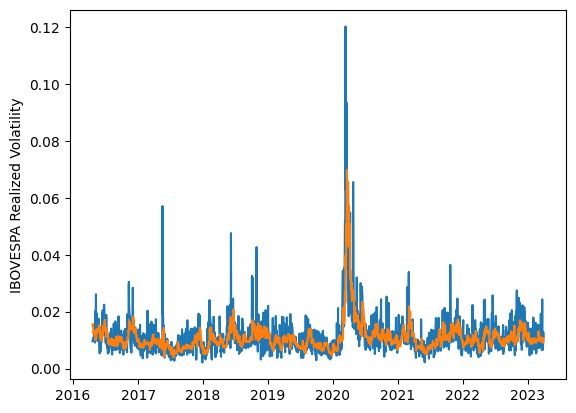

In [62]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("IBOVESPA Realized Volatility")

# H=5 Forecasts

In [63]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [64]:
for i in range(15):
  model = NBEATSx(h=5, input_size=12,
                  loss=MAE(),
                  scaler_type='robust',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 84724552


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 98391953


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62586698


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 49178919


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 81290665


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 56005023


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 26481307


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 77523744


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59733895


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 73404826


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 65645898


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 53232141


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 13856710


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 12182116


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 1992170


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [65]:
RMSE

[0.0036463953773391514,
 0.0036380923349262333,
 0.003640635750583907,
 0.0036725640217226767,
 0.0036315920499244486,
 0.003662713144811109,
 0.003626588811091917,
 0.003660552272482295,
 0.0036809603358769196,
 0.003662028851574517,
 0.0036713014523995437,
 0.003646992978738291,
 0.0036311379177929753,
 0.003641098480080241,
 0.003649801116195057]

In [66]:
Accuracy

[67.81968058146491,
 67.596800089241,
 67.74133971174233,
 67.50314062146168,
 67.96318338467377,
 67.55431958140386,
 67.6814973399598,
 67.46421389189669,
 66.6585809046195,
 66.85082925671747,
 67.59895516473593,
 67.74006159249522,
 67.80768579544849,
 68.09723936142267,
 67.74754309264036]

In [67]:
Quasilikelihood

[0.08503894603680147,
 0.0830150651989618,
 0.0849392805780284,
 0.08644914728698411,
 0.08507554057391438,
 0.08608091101733661,
 0.08388462018294333,
 0.08505170740869414,
 0.08212447799968678,
 0.082401535794349,
 0.08529249955373337,
 0.0857654560894402,
 0.08401348744890298,
 0.08681727384979004,
 0.085316229621115]

Text(0, 0.5, 'IBOVESPA Realized Volatility')

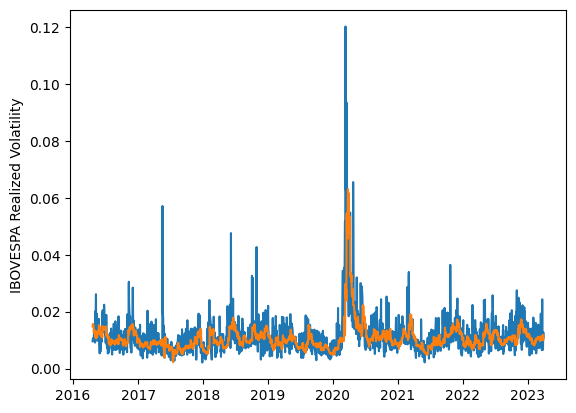

In [68]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("IBOVESPA Realized Volatility")

# H=10 Forecasts

In [69]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [70]:
for i in range(15):
  model = NBEATSx(h=10, input_size=12,
                  loss=MAE(),
                  scaler_type='robust',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=10,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%10,step_size=10)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 3686366


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 81079236


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 93637154


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 4144127


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 109934048


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62990255


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 78680002


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 77038852


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 113194544


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 116798456


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 81622381


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80813


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 31498087


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 6632457


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 44165558


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [71]:
RMSE

[0.003926649405903036,
 0.0039059862806244167,
 0.003910310572346821,
 0.003909256908442225,
 0.0039051555141311335,
 0.0039025436257575483,
 0.003871236347478632,
 0.003936399025868104,
 0.0038713816954040184,
 0.003877916469367509,
 0.003876761515224126,
 0.00388643153778844,
 0.0039009530534991122,
 0.003946200197341978,
 0.003936270920416976]

In [72]:
Accuracy

[65.39267619797681,
 66.05318254509673,
 65.47689480822199,
 65.61076127176537,
 66.0005995544374,
 66.00846783010266,
 66.07363460826585,
 65.43900325485342,
 66.37969989660557,
 66.01647849176031,
 66.03064708535373,
 66.11536074726725,
 66.3503838090841,
 65.77201348898389,
 65.52325185325363]

In [73]:
Quasilikelihood

[0.09502136204300456,
 0.09618964988990068,
 0.09400360399696679,
 0.0950021828973262,
 0.09776128917692603,
 0.09811738012010296,
 0.09466514715375107,
 0.09611663686212372,
 0.09472507752063129,
 0.09357552271510391,
 0.09503507533607414,
 0.09557881681740749,
 0.09896556837916365,
 0.0974628222341253,
 0.09610412142454093]

Text(0, 0.5, 'IBOVESPA Realized Volatility')

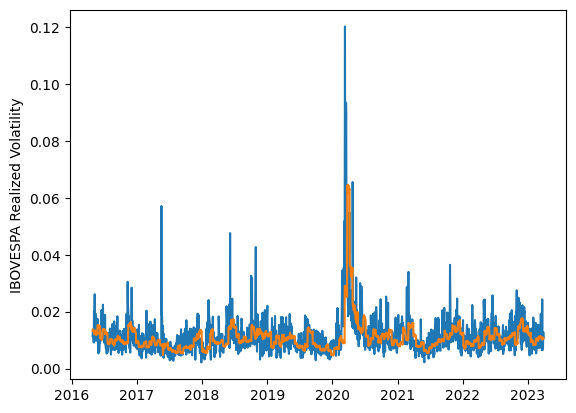

In [74]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("IBOVESPA Realized Volatility")

# H=22 Forecasts

In [75]:
Accuracy=[]
RMSE=[]
Quasilikelihood=[]

In [76]:
for i in range(15):
  model = NBEATSx(h=22, input_size=12,
                  loss=MAE(),
                  scaler_type='robust',
                  learning_rate= 0.0005,
                  stack_types=['trend','identity'],
                  n_blocks=[1,1],
                  mlp_units= [[512, 512], [512, 512]],
                  windows_batch_size=60,
                  num_lr_decays=5,
                  val_check_steps=100,
                  n_harmonics=0, n_polynomials=1,
                  hist_exog_list=['VIX'],
                  max_steps=150,
                  early_stop_patience_steps=1,
                  random_seed=randrange(129228148)
                  )
  fcst = NeuralForecast(models=[model],freq=Business_Days)
  forecasts = fcst.cross_validation(df=df,val_size=22,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%22,step_size=22)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE.append(np.sum(np.sqrt((Y_true-Y_hat)**2))/len(Y_true))
  Accuracy.append((1-np.sum(np.sqrt((Y_true-Y_hat)**2)/Y_true)/(len(Y_true)))*100)
  Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 105088914


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 77977052


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59509329


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124296878


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 48353393


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 82762495


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 28026120


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 72890580


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 59744812


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 116647648


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 87902897


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 11065571


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80698229


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 83682051


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 23272819


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [77]:
RMSE

[0.004365906439653615,
 0.004327292283657869,
 0.004293667263619793,
 0.004332900524180492,
 0.004301201799129855,
 0.004330343699608984,
 0.004284983748192899,
 0.004307178847870177,
 0.004342870743818486,
 0.004356113630905698,
 0.004328504245356937,
 0.004320098102618478,
 0.0043390783562582734,
 0.004394823204214936,
 0.004289201161459515]

In [78]:
Accuracy

[63.089515265113214,
 63.473857232575014,
 63.98128873839132,
 62.96365394330172,
 63.69431529936116,
 63.55876250591671,
 64.13662533821929,
 63.78392416189161,
 63.491646640825785,
 62.887399684953806,
 63.6756404872886,
 63.535059031014065,
 63.47419841109229,
 62.894102184313525,
 63.79805565945477]

In [79]:
Quasilikelihood

[0.1346881757709424,
 0.12975503219188178,
 0.13009893953670337,
 0.1286679310067453,
 0.1291733299466996,
 0.12949315155279467,
 0.12688861453623274,
 0.12623571807057365,
 0.13059975451134243,
 0.13279814769766818,
 0.1291781361284616,
 0.12750734853227358,
 0.1276975937336188,
 0.1314087012945332,
 0.12793439212295415]

Text(0, 0.5, 'IBOVESPA Realized Volatility')

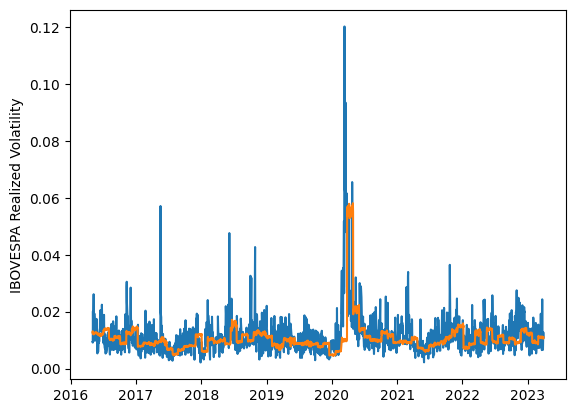

In [80]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("IBOVESPA Realized Volatility")